<a href="https://colab.research.google.com/github/mohitvermax/credit-card-default-prediction/blob/main/Credit_Card_Default_Prediction_Finclub_Open_Project_Mohit_Verma_23112063.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Project Setup and Instructions

## 🏦 Credit Card Default Prediction Using Advanced ML Techniques
**Finance Club Summer 2025 Project**

### Executive Summary
This project develops a sophisticated forward-looking Behavior Score to predict credit card defaults
one month in advance. Using over 30,000 customer records, we implement advanced feature engineering,
handle class imbalance, and compare multiple ML algorithms to create a production-ready risk model.

**Key Objectives:**
- Build binary classification model for default prediction
- Handle severe class imbalance using multiple techniques  
- Engineer financially meaningful features
- Compare 5+ ML algorithms across different data balancing methods
- Optimize business-relevant thresholds
- Generate production-style predictions

**Business Impact:**
Early identification of high-risk customers enables proactive risk management,
optimized credit exposure, and targeted intervention strategies.


In [ ]:
# Install required packages
!pip install xgboost lightgbm imbalanced-learn -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully!")
print("🚀 Ready to start credit default prediction analysis")

✅ Libraries imported successfully!
🚀 Ready to start credit default prediction analysis


# DATA LOADING AND INITIAL EXPLORATION

In [ ]:
# Option 1: Upload files directly
from google.colab import files
print("📁 Please upload your training dataset:")
uploaded = files.upload()
train_filename = list(uploaded.keys())[0]

print("\n📁 Please upload your validation dataset:")
uploaded_val = files.upload()
val_file = list(uploaded_val.keys())[0]

# Load the datasets
val_df = pd.read_csv(val_file)
train_df = pd.read_csv(train_filename)


print(f"📊 Training data loaded: {train_df.shape}")
print("\n🔍 First few rows:")
print(train_df.head())

# Basic dataset information
print(f"\n📋 Dataset Overview:")
print(f"Shape: {train_df.shape}")
print(f"Columns: {list(train_df.columns)}")
print(f"\nData types:\n{train_df.dtypes}")
print(f"\nMissing values:\n{train_df.isnull().sum()}")
print(f"\nBasic statistics:\n{train_df.describe()}")

# Target variable analysis
target_col = 'next_month_default'  # Adjust if your column name is different
print(f"\n🎯 Target Variable Analysis:")
print(f"Default rate: {train_df[target_col].mean():.2%}")
print(f"Class distribution:\n{train_df[target_col].value_counts()}")
print(f"Class ratio (0:1): {(train_df[target_col]==0).sum():.0f}:{(train_df[target_col]==1).sum():.0f}")




📁 Please upload your training dataset:


Saving train_dataset_final1.csv to train_dataset_final1.csv

📁 Please upload your validation dataset:


Saving validate_dataset_final.csv to validate_dataset_final.csv
📊 Training data loaded: (25247, 27)

🔍 First few rows:
   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2    0          2      60000  25.0      2      2   
1         5018         2    1          1     290000  24.0      0      0   
2         5019         1    0          2     180000  63.0      0      0   
3         5020         1    1          2     210000  43.0      0      0   
4         5021         2    0          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1     -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2      0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3      0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4     -2     -2  ...       1.35    999.78   3186.27  45

# COMPREHENSIVE EXPLORATORY DATA ANALYSIS

✅ Filled missing 'age' values with median: 34.0
🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS


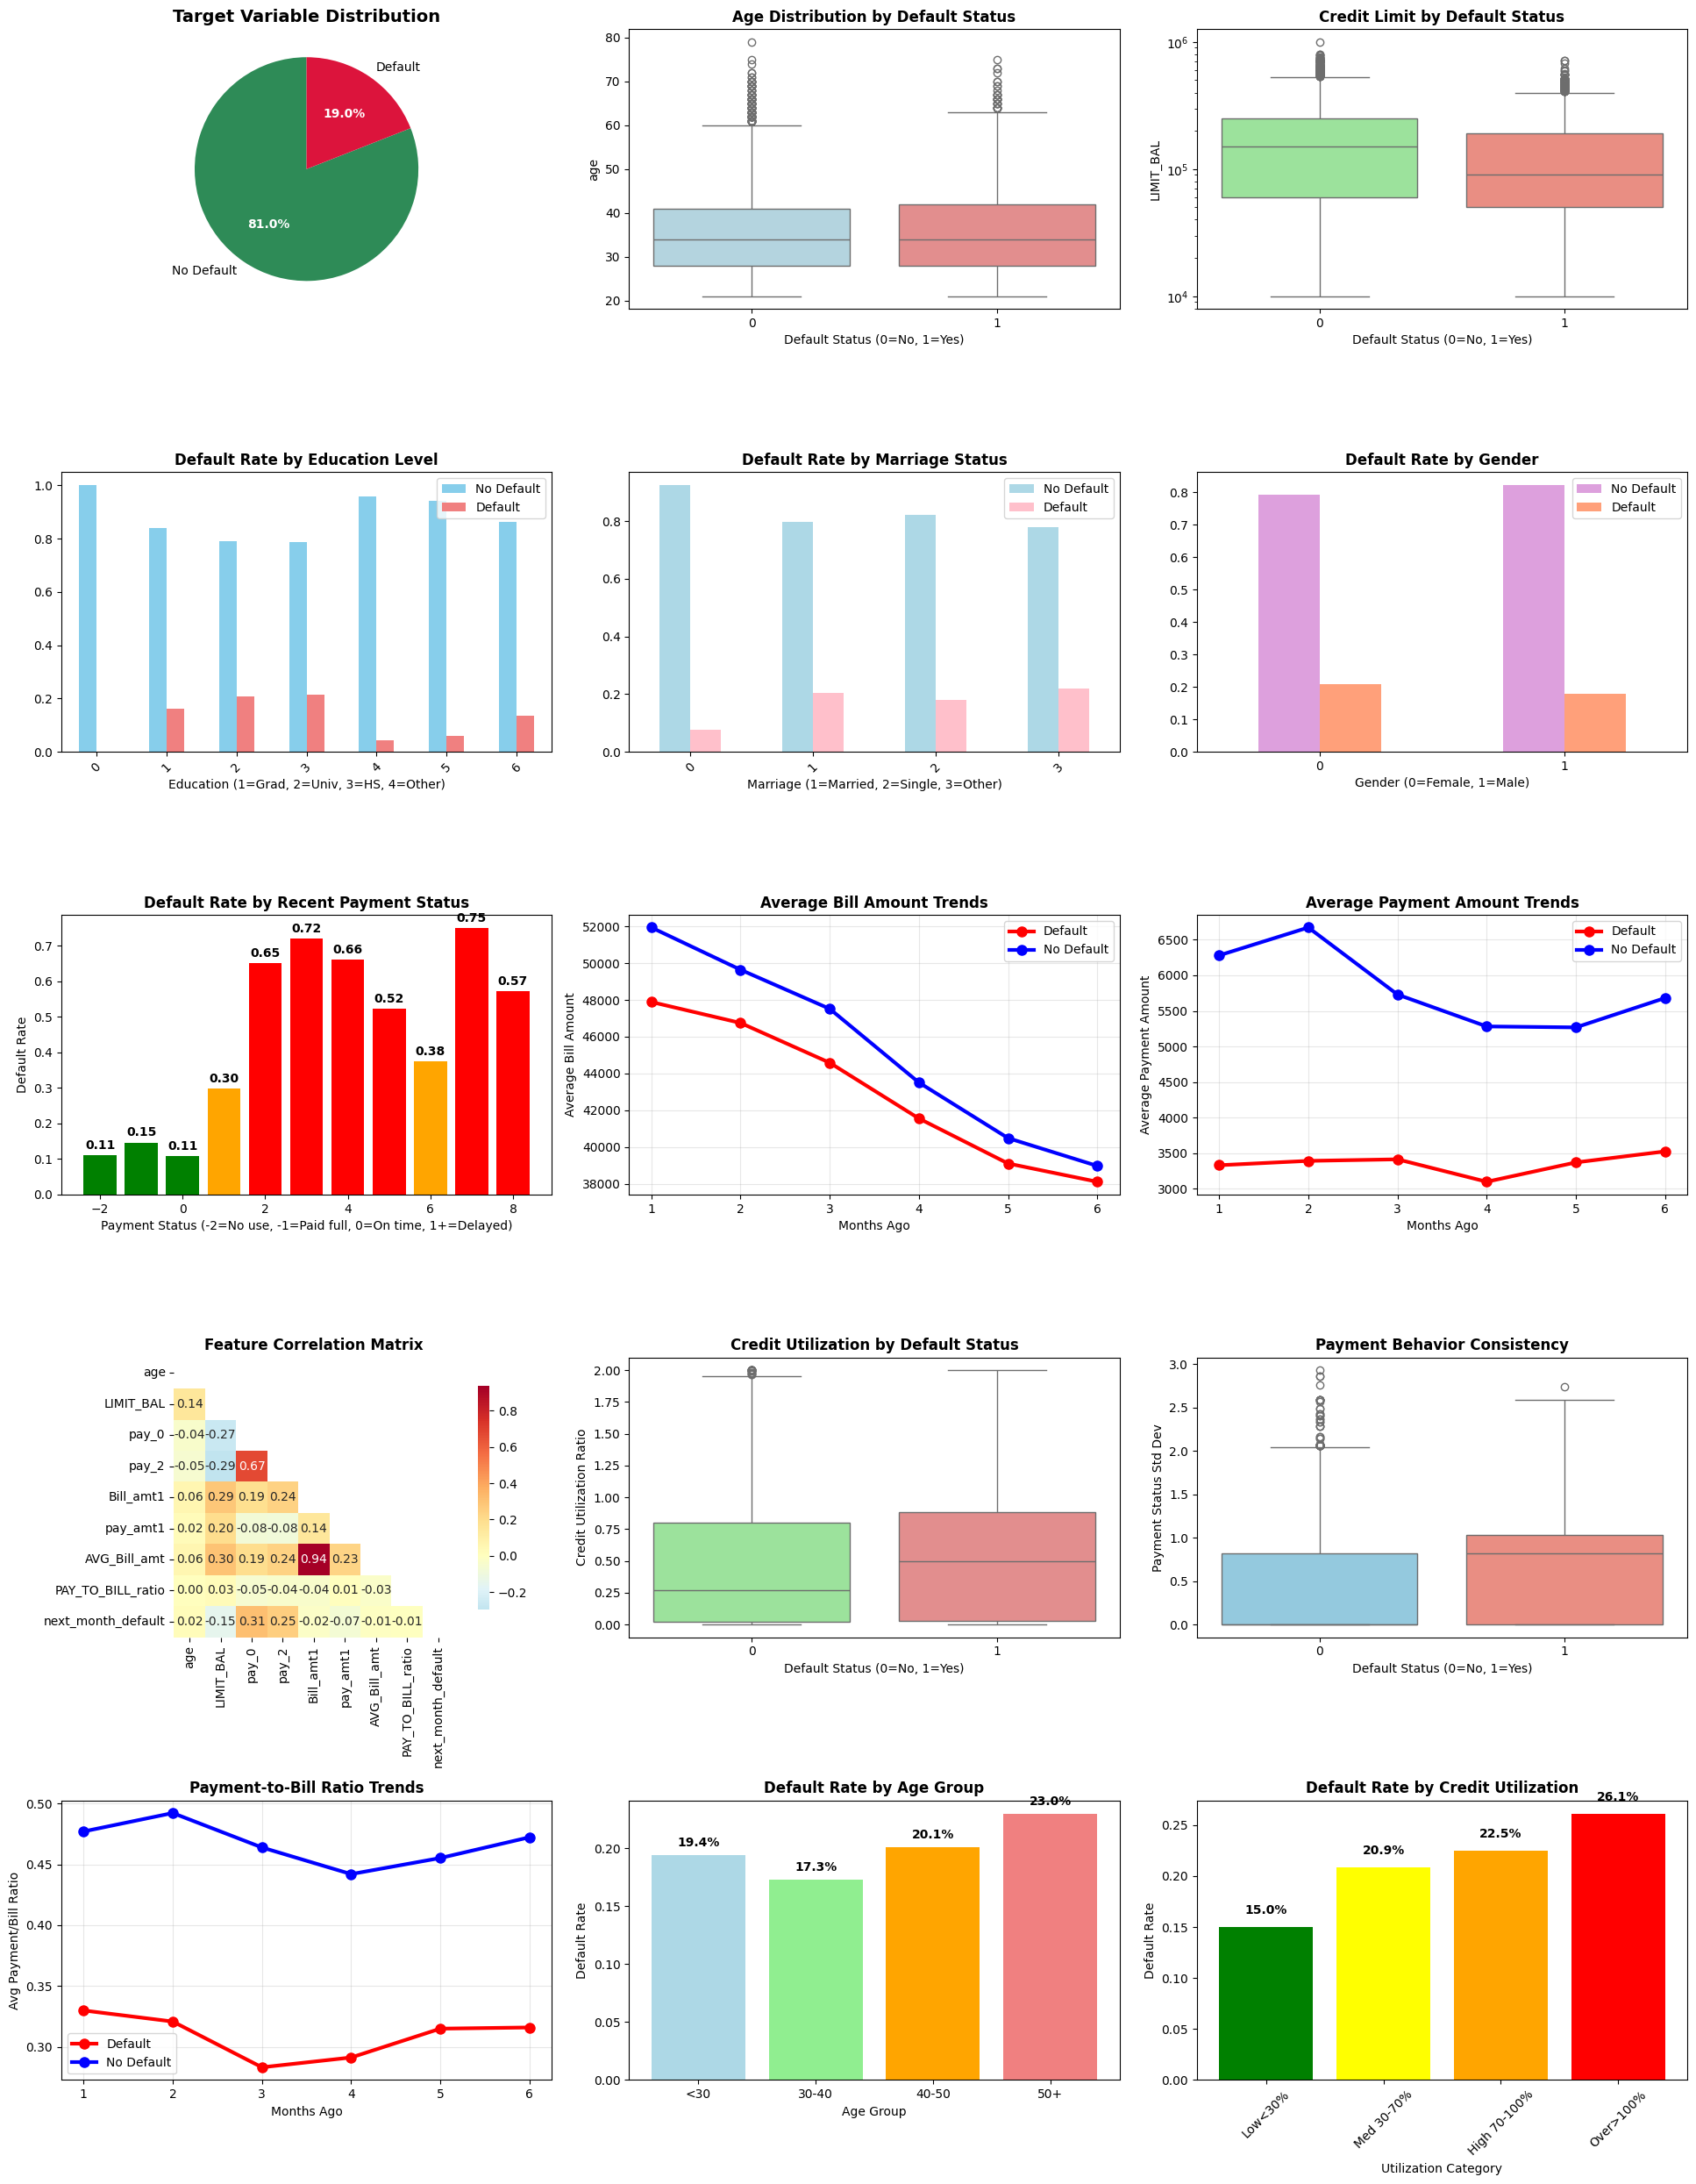


🎯 KEY FINANCIAL INSIGHTS:

1. 📊 PAYMENT BEHAVIOR ANALYSIS:
   Payment Status -2: 11.1% default rate (2,331 customers)
   Payment Status -1: 14.6% default rate (4,821 customers)
   Payment Status 0: 10.8% default rate (12,667 customers)
   Payment Status 1: 29.9% default rate (3,030 customers)
   Payment Status 2: 65.1% default rate (2,047 customers)
   Payment Status 3: 72.1% default rate (244 customers)
   Payment Status 4: 66.1% default rate (56 customers)
   Payment Status 5: 52.4% default rate (21 customers)
   Payment Status 6: 37.5% default rate (8 customers)
   Payment Status 7: 75.0% default rate (8 customers)
   Payment Status 8: 57.1% default rate (14 customers)

2. 💳 CREDIT LIMIT ANALYSIS:
   Average limit (Non-defaulters): $177,539
   Average limit (Defaulters): $129,234
   Difference: $48,305

3. 👥 DEMOGRAPHIC INSIGHTS:
   Average age (Non-defaulters): 35.4 years
   Average age (Defaulters): 35.8 years

4. 🎓 EDUCATION IMPACT:
   Level 0: 0.0% default rate (14 customers)
 

In [ ]:
median_age = train_df['age'].median()
train_df['age'].fillna(median_age, inplace=True)
print(f"✅ Filled missing 'age' values with median: {median_age}")

def perform_comprehensive_eda(df, target_col='next_month_default'):
    """
    Comprehensive EDA with financial domain insights
    """
    print("🔍 COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("="*60)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 25))

    # 1. Target distribution
    plt.subplot(5, 3, 1)
    target_counts = df[target_col].value_counts()
    colors = ['#2E8B57', '#DC143C']
    wedges, texts, autotexts = plt.pie(target_counts.values, labels=['No Default', 'Default'],
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')

    # 2. Age analysis
    plt.subplot(5, 3, 2)
    sns.boxplot(data=df, x=target_col, y='age', palette=['lightblue', 'lightcoral'])
    plt.title('Age Distribution by Default Status', fontweight='bold')
    plt.xlabel('Default Status (0=No, 1=Yes)')

    # 3. Credit limit analysis
    plt.subplot(5, 3, 3)
    sns.boxplot(data=df, x=target_col, y='LIMIT_BAL', palette=['lightgreen', 'salmon'])
    plt.title('Credit Limit by Default Status', fontweight='bold')
    plt.xlabel('Default Status (0=No, 1=Yes)')
    plt.yscale('log')

    # 4. Education analysis
    plt.subplot(5, 3, 4)
    education_default = pd.crosstab(df['education'], df[target_col], normalize='index')
    education_default.plot(kind='bar', ax=plt.gca(), color=['skyblue', 'lightcoral'])
    plt.title('Default Rate by Education Level', fontweight='bold')
    plt.xlabel('Education (1=Grad, 2=Univ, 3=HS, 4=Other)')
    plt.xticks(rotation=45)
    plt.legend(['No Default', 'Default'], loc='upper right')

    # 5. Marriage analysis
    plt.subplot(5, 3, 5)
    marriage_default = pd.crosstab(df['marriage'], df[target_col], normalize='index')
    marriage_default.plot(kind='bar', ax=plt.gca(), color=['lightblue', 'pink'])
    plt.title('Default Rate by Marriage Status', fontweight='bold')
    plt.xlabel('Marriage (1=Married, 2=Single, 3=Other)')
    plt.xticks(rotation=45)
    plt.legend(['No Default', 'Default'], loc='upper right')

    # 6. Gender analysis
    plt.subplot(5, 3, 6)
    gender_default = pd.crosstab(df['sex'], df[target_col], normalize='index')
    gender_default.plot(kind='bar', ax=plt.gca(), color=['plum', 'lightsalmon'])
    plt.title('Default Rate by Gender', fontweight='bold')
    plt.xlabel('Gender (0=Female, 1=Male)')
    plt.xticks(rotation=0)
    plt.legend(['No Default', 'Default'], loc='upper right')

    # 7. Payment status analysis
    plt.subplot(5, 3, 7)
    pay_0_default = df.groupby('pay_0')[target_col].mean().sort_index()
    bars = plt.bar(pay_0_default.index, pay_0_default.values,
                   color=['green' if x < 0.2 else 'orange' if x < 0.4 else 'red' for x in pay_0_default.values])
    plt.title('Default Rate by Recent Payment Status', fontweight='bold')
    plt.xlabel('Payment Status (-2=No use, -1=Paid full, 0=On time, 1+=Delayed)')
    plt.ylabel('Default Rate')

    # Add value labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

    # 8. Bill amount trends
    plt.subplot(5, 3, 8)
    bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
    avg_bills_default = df[df[target_col]==1][bill_cols].mean()
    avg_bills_no_default = df[df[target_col]==0][bill_cols].mean()

    x = range(len(bill_cols))
    plt.plot(x, avg_bills_default, 'ro-', label='Default', linewidth=3, markersize=8)
    plt.plot(x, avg_bills_no_default, 'bo-', label='No Default', linewidth=3, markersize=8)
    plt.title('Average Bill Amount Trends', fontweight='bold')
    plt.xlabel('Months Ago')
    plt.ylabel('Average Bill Amount')
    plt.xticks(x, ['1', '2', '3', '4', '5', '6'])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 9. Payment trends
    plt.subplot(5, 3, 9)
    pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
    avg_pays_default = df[df[target_col]==1][pay_cols].mean()
    avg_pays_no_default = df[df[target_col]==0][pay_cols].mean()

    plt.plot(x, avg_pays_default, 'ro-', label='Default', linewidth=3, markersize=8)
    plt.plot(x, avg_pays_no_default, 'bo-', label='No Default', linewidth=3, markersize=8)
    plt.title('Average Payment Amount Trends', fontweight='bold')
    plt.xlabel('Months Ago')
    plt.ylabel('Average Payment Amount')
    plt.xticks(x, ['1', '2', '3', '4', '5', '6'])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 10. Correlation heatmap
    plt.subplot(5, 3, 10)
    key_features = ['age', 'LIMIT_BAL', 'pay_0', 'pay_2', 'Bill_amt1', 'pay_amt1',
                   'AVG_Bill_amt', 'PAY_TO_BILL_ratio', target_col]
    corr_matrix = df[key_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
               square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix', fontweight='bold')

    # 11. Credit utilization analysis
    plt.subplot(5, 3, 11)
    df['credit_utilization'] = df['Bill_amt1'] / (df['LIMIT_BAL'] + 1)
    df['credit_utilization'] = df['credit_utilization'].clip(0, 2)

    sns.boxplot(data=df, x=target_col, y='credit_utilization', palette=['lightgreen', 'lightcoral'])
    plt.title('Credit Utilization by Default Status', fontweight='bold')
    plt.xlabel('Default Status (0=No, 1=Yes)')
    plt.ylabel('Credit Utilization Ratio')

    # 12. Payment consistency
    plt.subplot(5, 3, 12)
    pay_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    df['pay_consistency'] = df[pay_status_cols].std(axis=1)

    sns.boxplot(data=df, x=target_col, y='pay_consistency', palette=['skyblue', 'salmon'])
    plt.title('Payment Behavior Consistency', fontweight='bold')
    plt.xlabel('Default Status (0=No, 1=Yes)')
    plt.ylabel('Payment Status Std Dev')

    # 13. Payment ratios over time
    plt.subplot(5, 3, 13)
    payment_ratios = []
    for i in range(1, 7):
        ratio = df[f'pay_amt{i}'] / (df[f'Bill_amt{i}'] + 1)
        payment_ratios.append(ratio.clip(0, 3))

    payment_ratio_df = pd.DataFrame(payment_ratios).T
    payment_ratio_df.columns = [f'Month_{i}' for i in range(1, 7)]
    payment_ratio_df['default'] = df[target_col].values

    avg_ratios_default = payment_ratio_df[payment_ratio_df['default']==1].iloc[:, :-1].mean()
    avg_ratios_no_default = payment_ratio_df[payment_ratio_df['default']==0].iloc[:, :-1].mean()

    x = range(6)
    plt.plot(x, avg_ratios_default, 'ro-', label='Default', linewidth=3, markersize=8)
    plt.plot(x, avg_ratios_no_default, 'bo-', label='No Default', linewidth=3, markersize=8)
    plt.title('Payment-to-Bill Ratio Trends', fontweight='bold')
    plt.xlabel('Months Ago')
    plt.ylabel('Avg Payment/Bill Ratio')
    plt.xticks(x, ['1', '2', '3', '4', '5', '6'])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 14. Risk distribution by age groups
    plt.subplot(5, 3, 14)
    df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 100], labels=['<30', '30-40', '40-50', '50+'])
    age_risk = df.groupby('age_group')[target_col].mean()
    bars = plt.bar(range(len(age_risk)), age_risk.values,
                   color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
    plt.title('Default Rate by Age Group', fontweight='bold')
    plt.xlabel('Age Group')
    plt.ylabel('Default Rate')
    plt.xticks(range(len(age_risk)), age_risk.index)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    # 15. Limit utilization distribution
    plt.subplot(5, 3, 15)
    df['util_category'] = pd.cut(df['credit_utilization'],
                                bins=[0, 0.3, 0.7, 1.0, 2.0],
                                labels=['Low<30%', 'Med 30-70%', 'High 70-100%', 'Over>100%'])
    util_risk = df.groupby('util_category')[target_col].mean()
    bars = plt.bar(range(len(util_risk)), util_risk.values,
                   color=['green', 'yellow', 'orange', 'red'])
    plt.title('Default Rate by Credit Utilization', fontweight='bold')
    plt.xlabel('Utilization Category')
    plt.ylabel('Default Rate')
    plt.xticks(range(len(util_risk)), util_risk.index, rotation=45)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.1%}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print key insights
    print("\n🎯 KEY FINANCIAL INSIGHTS:")
    print("="*50)

    print("\n1. 📊 PAYMENT BEHAVIOR ANALYSIS:")
    for status in sorted(df['pay_0'].unique()):
        count = (df['pay_0'] == status).sum()
        rate = df[df['pay_0']==status][target_col].mean()
        print(f"   Payment Status {status}: {rate:.1%} default rate ({count:,} customers)")

    print(f"\n2. 💳 CREDIT LIMIT ANALYSIS:")
    limit_default = df[df[target_col]==1]['LIMIT_BAL'].mean()
    limit_no_default = df[df[target_col]==0]['LIMIT_BAL'].mean()
    print(f"   Average limit (Non-defaulters): ${limit_no_default:,.0f}")
    print(f"   Average limit (Defaulters): ${limit_default:,.0f}")
    print(f"   Difference: ${limit_no_default - limit_default:,.0f}")

    print(f"\n3. 👥 DEMOGRAPHIC INSIGHTS:")
    age_default = df[df[target_col]==1]['age'].mean()
    age_no_default = df[df[target_col]==0]['age'].mean()
    print(f"   Average age (Non-defaulters): {age_no_default:.1f} years")
    print(f"   Average age (Defaulters): {age_default:.1f} years")

    print(f"\n4. 🎓 EDUCATION IMPACT:")
    for edu in sorted(df['education'].unique()):
        rate = df[df['education']==edu][target_col].mean()
        count = (df['education']==edu).sum()
        edu_labels = {1: 'Graduate', 2: 'University', 3: 'High School', 4: 'Others'}
        print(f"   {edu_labels.get(edu, f'Level {edu}')}: {rate:.1%} default rate ({count:,} customers)")

    print(f"\n5. 💰 UTILIZATION INSIGHTS:")
    high_util = df[df['credit_utilization'] > 0.8][target_col].mean()
    low_util = df[df['credit_utilization'] <= 0.3][target_col].mean()
    print(f"   High utilization (>80%): {high_util:.1%} default rate")
    print(f"   Low utilization (≤30%): {low_util:.1%} default rate")
    print(f"   Risk multiplier: {high_util/low_util:.1f}x higher risk")

    return df

# Run comprehensive EDA
train_df = perform_comprehensive_eda(train_df)



# ADVANCED FEATURE ENGINEERING

In [ ]:
def engineer_advanced_features(df):
    """
    Engineer advanced features based on financial domain knowledge
    """
    print("🛠️ ADVANCED FEATURE ENGINEERING")
    print("="*50)

    df_eng = df.copy()

    print("Creating financially meaningful features...")

    # 1. CREDIT UTILIZATION FEATURES
    print("1. Credit Utilization Features...")
    df_eng['credit_utilization_current'] = df_eng['Bill_amt1'] / (df_eng['LIMIT_BAL'] + 1)
        # Categorize utilization for risk bands
    def categorize_utilization(u):
        if u < 0.3:
            return 0  # Low utilization
        elif u < 0.6:
            return 1  # Moderate utilization
        elif u < 0.9:
            return 2  # High utilization
        else:
            return 3  # Very High utilization

    df_eng['util_category'] = df_eng['credit_utilization_current'].apply(categorize_utilization).astype(int)
    df_eng['credit_utilization_avg'] = df_eng['AVG_Bill_amt'] / (df_eng['LIMIT_BAL'] + 1)
    df_eng['utilization_volatility'] = df_eng[['Bill_amt1', 'Bill_amt2', 'Bill_amt3',
                                              'Bill_amt4', 'Bill_amt5', 'Bill_amt6']].std(axis=1) / (df_eng['LIMIT_BAL'] + 1)

    # 2. PAYMENT BEHAVIOR FEATURES
    print("2. Payment Behavior Features...")
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    df_eng['late_payments_count'] = (df_eng[pay_cols] > 0).sum(axis=1)
    df_eng['max_payment_delay'] = df_eng[pay_cols].max(axis=1)
    df_eng['payment_consistency'] = df_eng[pay_cols].std(axis=1)
    df_eng['recent_payment_trend'] = df_eng['pay_0'] - df_eng['pay_2']  # Improving or worsening
    df_eng['chronic_delinquent'] = (df_eng['late_payments_count'] >= 4).astype(int)

    # 3. FINANCIAL STABILITY INDICATORS
    print("3. Financial Stability Indicators...")
    bill_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
    pay_amount_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

    df_eng['bill_amount_volatility'] = df_eng[bill_cols].std(axis=1)
    df_eng['payment_amount_volatility'] = df_eng[pay_amount_cols].std(axis=1)
    df_eng['spending_trend'] = df_eng['Bill_amt1'] - df_eng['Bill_amt6']  # Increasing/decreasing spending
    df_eng['payment_trend'] = df_eng['pay_amt1'] - df_eng['pay_amt6']  # Payment behavior trend

    # 4. PAYMENT-TO-LIMIT RATIOS
    print("4. Payment Capacity Features...")
    df_eng['avg_payment_to_limit'] = df_eng[pay_amount_cols].mean(axis=1) / (df_eng['LIMIT_BAL'] + 1)
    df_eng['max_payment_to_limit'] = df_eng[pay_amount_cols].max(axis=1) / (df_eng['LIMIT_BAL'] + 1)
    df_eng['payment_capacity'] = df_eng['PAY_TO_BILL_ratio']  # Already exists, but emphasize

    # 5. RISK INDICATOR FLAGS
    print("5. Risk Indicator Flags...")
    df_eng['high_utilization_flag'] = (df_eng['credit_utilization_current'] > 0.8).astype(int)
    df_eng['minimal_payment_flag'] = (df_eng['PAY_TO_BILL_ratio'] < 0.1).astype(int)
    df_eng['no_recent_payment'] = (df_eng['pay_amt1'] == 0).astype(int)
    df_eng['maxed_out_card'] = (df_eng['credit_utilization_current'] > 0.95).astype(int)

    # 6. DEMOGRAPHIC RISK FACTORS
    print("6. Demographic Risk Profiling...")
    df_eng['young_high_limit'] = ((df_eng['age'] < 30) & (df_eng['LIMIT_BAL'] > 50000)).astype(int)
    df_eng['education_risk_flag'] = (df_eng['education'] >= 3).astype(int)  # High school or below
    df_eng['age_risk_category'] = pd.cut(df_eng['age'], bins=[0, 25, 35, 50, 100],
                                        labels=[3, 2, 1, 0]).astype(int)  # Higher number = higher risk

    # 7. INTERACTION FEATURES
    print("7. Interaction Features...")
    df_eng['age_limit_interaction'] = df_eng['age'] * np.log1p(df_eng['LIMIT_BAL'])
    df_eng['utilization_payment_interaction'] = df_eng['credit_utilization_current'] * df_eng['PAY_TO_BILL_ratio']
    df_eng['age_education_risk'] = df_eng['age_risk_category'] * df_eng['education_risk_flag']

    # 8. PAYMENT PATTERN ANALYSIS
    print("8. Payment Pattern Analysis...")
    # Calculate payment consistency across months
    payment_ratios = []
    for i in range(1, 7):
        ratio = df_eng[f'pay_amt{i}'] / (df_eng[f'Bill_amt{i}'] + 1)
        payment_ratios.append(ratio.fillna(0).clip(0, 5))  # Cap at 500%

    payment_ratio_df = pd.DataFrame(payment_ratios).T
    df_eng['payment_ratio_consistency'] = payment_ratio_df.std(axis=1)
    df_eng['avg_payment_ratio'] = payment_ratio_df.mean(axis=1)
    df_eng['declining_payments'] = (payment_ratio_df.iloc[:, 0] < payment_ratio_df.iloc[:, -1]).astype(int)

    # 9. ADVANCED CREDIT BEHAVIOR
    print("9. Advanced Credit Behavior...")
    df_eng['credit_dependency'] = df_eng['AVG_Bill_amt'] / (df_eng['LIMIT_BAL'] + 1)
    df_eng['payment_shock_resilience'] = df_eng[pay_amount_cols].min(axis=1) / (df_eng[pay_amount_cols].max(axis=1) + 1)

    # 10. FINANCIAL STRESS INDICATORS
    print("10. Financial Stress Indicators...")
    df_eng['increasing_debt'] = (df_eng['Bill_amt1'] > df_eng['Bill_amt6']).astype(int)
    df_eng['decreasing_payments'] = (df_eng['pay_amt1'] < df_eng['pay_amt6']).astype(int)
    df_eng['financial_stress_score'] = (df_eng['increasing_debt'] +
                                       df_eng['decreasing_payments'] +
                                       df_eng['high_utilization_flag'] +
                                       df_eng['minimal_payment_flag'])

    # Display new features created
    original_features = set(df.columns)
    new_features = [col for col in df_eng.columns if col not in original_features]

    print(f"\n✅ Feature Engineering Complete!")
    print(f"📊 Created {len(new_features)} new features:")

    feature_categories = {
        'Credit Utilization': ['credit_utilization_current', 'credit_utilization_avg', 'utilization_volatility', 'credit_dependency'],
        'Payment Behavior': ['late_payments_count', 'max_payment_delay', 'payment_consistency', 'recent_payment_trend', 'chronic_delinquent'],
        'Financial Stability': ['bill_amount_volatility', 'payment_amount_volatility', 'spending_trend', 'payment_trend'],
        'Risk Flags': ['high_utilization_flag', 'minimal_payment_flag', 'no_recent_payment', 'maxed_out_card'],
        'Demographic Risk': ['young_high_limit', 'education_risk_flag', 'age_risk_category'],
        'Interactions': ['age_limit_interaction', 'utilization_payment_interaction', 'age_education_risk'],
        'Payment Patterns': ['payment_ratio_consistency', 'avg_payment_ratio', 'declining_payments'],
        'Stress Indicators': ['increasing_debt', 'decreasing_payments', 'financial_stress_score', 'payment_shock_resilience']
    }

    for category, features in feature_categories.items():
        existing_features = [f for f in features if f in new_features]
        if existing_features:
            print(f"\n   {category}:")
            for feature in existing_features:
                print(f"     • {feature}")

    df_eng['age_group'] = pd.cut(df_eng['age'], bins=[0, 30, 40, 50, np.inf],
                             labels=[0, 1, 2, 3]).astype(int)

    return df_eng

# Apply feature engineering
train_df_engineered = engineer_advanced_features(train_df)
# age_group_map = {'<30': 0, '30-40': 1, '40-50': 2, '50+': 3}
# train_df_engineered['age_group'] = train_df_engineered['age_group'].map(age_group_map)
# train_df_engineered['age_group'] = train_df_engineered['age_group'].astype(int)


print(f"\n📈 Dataset shape after feature engineering: {train_df_engineered.shape}")


🛠️ ADVANCED FEATURE ENGINEERING
Creating financially meaningful features...
1. Credit Utilization Features...
2. Payment Behavior Features...
3. Financial Stability Indicators...
4. Payment Capacity Features...
5. Risk Indicator Flags...
6. Demographic Risk Profiling...
7. Interaction Features...
8. Payment Pattern Analysis...
9. Advanced Credit Behavior...
10. Financial Stress Indicators...

✅ Feature Engineering Complete!
📊 Created 33 new features:

   credit_utilization:
     • credit_utilization_current
     • credit_utilization_avg
     • utilization_volatility
     • credit_dependency

   Payment Behavior:
     • late_payments_count
     • max_payment_delay
     • payment_consistency
     • recent_payment_trend
     • chronic_delinquent

   Financial Stability:
     • bill_amount_volatility
     • payment_amount_volatility
     • spending_trend
     • payment_trend

   Risk Flags:
     • high_utilization_flag
     • minimal_payment_flag
     • no_recent_payment
     • maxed_out_c

# Data Preparation and Train-Test Split

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

print("📋 Preparing data for modeling...")

# Define features to exclude
exclude_cols = ['Customer_ID', 'next_month_default']
feature_cols = [col for col in train_df_engineered.columns if col not in exclude_cols]

# Prepare features and target
X_train = train_df_engineered[feature_cols]
y_train = train_df_engineered['next_month_default']

print(f"Training features shape: {X_train.shape}")
print(f"Training target distribution: {y_train.value_counts().to_dict()}")

# Check for mixed types
for col in X_train.columns:
    unique_types = X_train[col].map(type).nunique()
    if unique_types > 1:
        print(f"⚠️ Column '{col}' has mixed types: {[type(val) for val in X_train[col].unique()[:5]]}")

# Check for object or string columns
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
if non_numeric_cols:
    print("\n🔍 Non-numeric columns that will cause StandardScaler to fail:")
    for col in non_numeric_cols:
        unique_vals = X_train[col].unique()
        print(f"  - {col}: {unique_vals[:5]}{'...' if len(unique_vals) > 5 else ''}")

    # Optionally, convert these columns using one-hot encoding or label encoding
    print("\n📌 Fix suggestion: Convert non-numeric columns using encoding before scaling.")
    # Example:
    # X_train = pd.get_dummies(X_train, columns=non_numeric_cols)
    raise ValueError("❌ Cannot scale non-numeric data. See list above.")
else:
    print("✅ All features are numeric. Proceeding to scaling...")

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(f"✅ Scaled training features shape: {X_train_scaled.shape}")
print(f"Using complete training set: {X_train.shape[0]} samples")
print(f"Total features after engineering: {X_train.shape[1]}")

# Display feature list
print(f"\nEngineered Features ({len(feature_cols)}):")
for i, feature in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {feature}")


📋 Preparing data for modeling...
Training features shape: (25247, 62)
Training target distribution: {0: 20440, 1: 4807}
✅ All features are numeric. Proceeding to scaling...
✅ Scaled training features shape: (25247, 62)
Using complete training set: 25247 samples
Total features after engineering: 62

Engineered Features (62):
   1. marriage
   2. sex
   3. education
   4. LIMIT_BAL
   5. age
   6. pay_0
   7. pay_2
   8. pay_3
   9. pay_4
  10. pay_5
  11. pay_6
  12. Bill_amt1
  13. Bill_amt2
  14. Bill_amt3
  15. Bill_amt4
  16. Bill_amt5
  17. Bill_amt6
  18. pay_amt1
  19. pay_amt2
  20. pay_amt3
  21. pay_amt4
  22. pay_amt5
  23. pay_amt6
  24. AVG_Bill_amt
  25. PAY_TO_BILL_ratio
  26. credit_utilization
  27. pay_consistency
  28. age_group
  29. util_category
  30. credit_utilization_current
  31. credit_utilization_avg
  32. utilization_volatility
  33. late_payments_count
  34. max_payment_delay
  35. payment_consistency
  36. recent_payment_trend
  37. chronic_delinquent
  38

# Class Imbalance Analysis and Handling

⚖️ Analyzing and handling class imbalance...
Original class distribution:
  Class 0 (No Default): 20,440 (81.0%)
  Class 1 (Default): 4,807 (19.0%)
  Imbalance ratio: 4.3:1

🔄 Applying SMOTE...
SMOTE distribution: {0: 20440, 1: 20440}

🔄 Applying SMOTE + Tomek Links...
SMOTE+Tomek distribution: {0: 20315, 1: 20315}

🔄 Applying Random Under-sampling...
Under-sampling distribution: {0: 8011, 1: 4807}


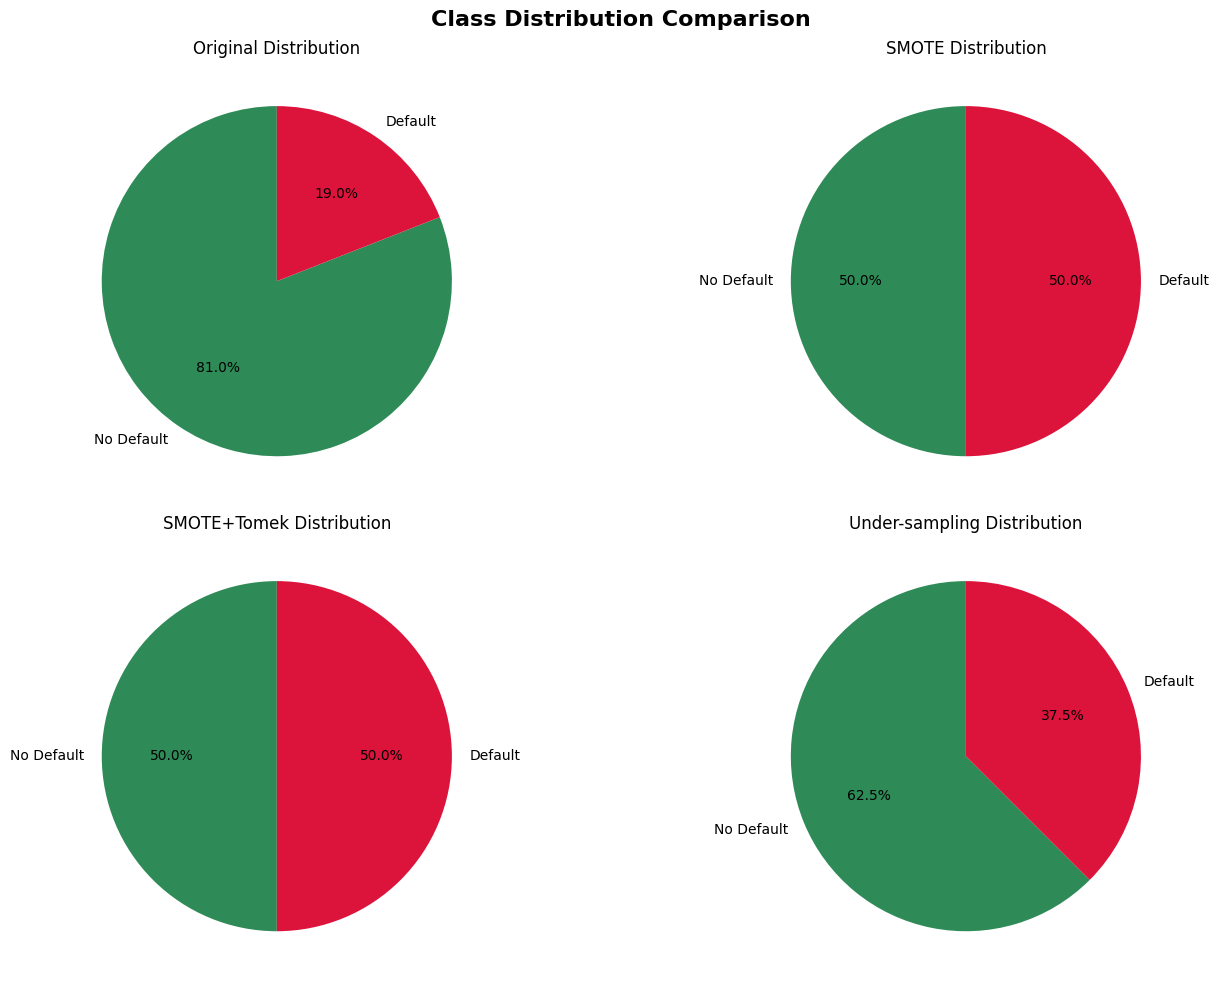

In [ ]:

print("⚖️ Analyzing and handling class imbalance...")

# Analyze current class distribution
class_distribution = y_train.value_counts()
print(f"Original class distribution:")
print(f"  Class 0 (No Default): {class_distribution[0]:,} ({class_distribution[0]/len(y_train):.1%})")
print(f"  Class 1 (Default): {class_distribution[1]:,} ({class_distribution[1]/len(y_train):.1%})")
print(f"  Imbalance ratio: {class_distribution[0]/class_distribution[1]:.1f}:1")

# Prepare different balanced datasets
balanced_datasets = {}

# 1. SMOTE (Synthetic Minority Over-sampling Technique)
print("\n🔄 Applying SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
balanced_datasets['SMOTE'] = (X_smote, y_smote)
smote_dist = pd.Series(y_smote).value_counts()
print(f"SMOTE distribution: {smote_dist.to_dict()}")

# 2. SMOTE + Tomek Links (Hybrid approach)
print("\n🔄 Applying SMOTE + Tomek Links...")
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train_scaled, y_train)
balanced_datasets['SMOTE_Tomek'] = (X_smote_tomek, y_smote_tomek)
smote_tomek_dist = pd.Series(y_smote_tomek).value_counts()
print(f"SMOTE+Tomek distribution: {smote_tomek_dist.to_dict()}")

# 3. Random Under-sampling with 60:40 ratio
print("\n🔄 Applying Random Under-sampling...")
under_sampler = RandomUnderSampler(random_state=42, sampling_strategy=0.6)
X_under, y_under = under_sampler.fit_resample(X_train_scaled, y_train)
balanced_datasets['UnderSample'] = (X_under, y_under)
under_dist = pd.Series(y_under).value_counts()
print(f"Under-sampling distribution: {under_dist.to_dict()}")

# Visualize class distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Class Distribution Comparison', fontsize=16, fontweight='bold')

# Original distribution
axes[0,0].pie(class_distribution.values, labels=['No Default', 'Default'],
              autopct='%1.1f%%', colors=['#2E8B57', '#DC143C'], startangle=90)
axes[0,0].set_title('Original Distribution')

# SMOTE distribution
axes[0,1].pie(smote_dist.values, labels=['No Default', 'Default'],
              autopct='%1.1f%%', colors=['#2E8B57', '#DC143C'], startangle=90)
axes[0,1].set_title('SMOTE Distribution')

# SMOTE+Tomek distribution
axes[1,0].pie(smote_tomek_dist.values, labels=['No Default', 'Default'],
              autopct='%1.1f%%', colors=['#2E8B57', '#DC143C'], startangle=90)
axes[1,0].set_title('SMOTE+Tomek Distribution')

# Under-sampling distribution
axes[1,1].pie(under_dist.values, labels=['No Default', 'Default'],
              autopct='%1.1f%%', colors=['#2E8B57', '#DC143C'], startangle=90)
axes[1,1].set_title('Under-sampling Distribution')

plt.tight_layout()
plt.show()


# Model Training and Comparison

In [ ]:

print("🤖 Training and comparing multiple models...")

# Define comprehensive model configurations
model_configs = {
    'LogisticRegression': LogisticRegression(
        random_state=42,
        max_iter=2000,
        solver='liblinear',
        class_weight='balanced'
    ),
    'DecisionTree': DecisionTreeClassifier(
        random_state=42,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced'
    ),
    'RandomForest': RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced'
    ),
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        verbosity=0
    ),
    'LightGBM': lgb.LGBMClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1,
        class_weight='balanced'
    )
}

# Cross-validation setup
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store all results
all_results = {}
cv_results = {}

# Train models on different balanced datasets
for balance_method, (X_bal, y_bal) in balanced_datasets.items():
    print(f"\n📊 Training models with {balance_method} (Size: {len(X_bal):,})...")

    for model_name, model in model_configs.items():
        print(f"  🔄 Training {model_name}...")

        # Cross-validation
        cv_scores = cross_val_score(model, X_bal, y_bal, cv=cv_strategy,
                                  scoring='roc_auc', n_jobs=-1)

        # Fit model on full balanced dataset
        model.fit(X_bal, y_bal)

        # Store cross-validation results
        key = f"{balance_method}_{model_name}"
        cv_results[key] = {
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'cv_scores': cv_scores
        }

        # Store trained model
        all_results[key] = {
            'model': model,
            'balance_method': balance_method,
            'model_name': model_name,
            'cv_auc_mean': cv_scores.mean(),
            'cv_auc_std': cv_scores.std()
        }

        print(f"    CV AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Display comprehensive results table
print("\n📈 Cross-Validation Results Summary:")
print("="*80)
print(f"{'Model':<15} {'Balance Method':<12} {'CV AUC Mean':<12} {'CV AUC Std':<12}")
print("="*80)

sorted_results = sorted(all_results.items(), key=lambda x: x[1]['cv_auc_mean'], reverse=True)
for key, result in sorted_results:
    print(f"{result['model_name']:<15} {result['balance_method']:<12} "
          f"{result['cv_auc_mean']:<12.4f} {result['cv_auc_std']:<12.4f}")


🤖 Training and comparing multiple models...

📊 Training models with SMOTE (Size: 40,880)...
  🔄 Training LogisticRegression...
    CV AUC: 0.7699 (±0.0038)
  🔄 Training DecisionTree...
    CV AUC: 0.8824 (±0.0033)
  🔄 Training RandomForest...
    CV AUC: 0.9173 (±0.0022)
  🔄 Training XGBoost...
    CV AUC: 0.9539 (±0.0012)
  🔄 Training LightGBM...
    CV AUC: 0.9496 (±0.0013)

📊 Training models with SMOTE_Tomek (Size: 40,630)...
  🔄 Training LogisticRegression...
    CV AUC: 0.7713 (±0.0040)
  🔄 Training DecisionTree...
    CV AUC: 0.8783 (±0.0026)
  🔄 Training RandomForest...
    CV AUC: 0.9188 (±0.0028)
  🔄 Training XGBoost...
    CV AUC: 0.9557 (±0.0030)
  🔄 Training LightGBM...
    CV AUC: 0.9515 (±0.0029)

📊 Training models with UnderSample (Size: 12,818)...
  🔄 Training LogisticRegression...
    CV AUC: 0.7635 (±0.0095)
  🔄 Training DecisionTree...
    CV AUC: 0.7030 (±0.0046)
  🔄 Training RandomForest...
    CV AUC: 0.7856 (±0.0087)
  🔄 Training XGBoost...
    CV AUC: 0.7733 (±0

# Model Selection and Hyperparameter Tuning

In [ ]:

print("\n🎯 Selecting best model and fine-tuning hyperparameters...")

# Select top 3 models for hyperparameter tuning
top_3_models = sorted_results[:3]
print(f"\nTop 3 models selected for hyperparameter tuning:")
for i, (key, result) in enumerate(top_3_models, 1):
    print(f"  {i}. {result['model_name']} with {result['balance_method']} "
          f"(CV AUC: {result['cv_auc_mean']:.4f})")

# Hyperparameter grids for top models
param_grids = {
    'XGBoost': {
        'n_estimators': [150, 200, 250],
        'max_depth': [6, 8, 10],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    },
    'LightGBM': {
        'n_estimators': [150, 200, 250],
        'max_depth': [8, 10, 12],
        'learning_rate': [0.05, 0.1, 0.15],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    },
    'RandomForest': {
        'n_estimators': [150, 200, 250],
        'max_depth': [10, 12, 15],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [2, 5, 8]
    },
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

# Perform hyperparameter tuning for top models
tuned_models = {}

for key, result in top_3_models:
    model_name = result['model_name']
    balance_method = result['balance_method']

    print(f"\n🔧 Hyperparameter tuning for {model_name} with {balance_method}...")

    if model_name in param_grids:
        # Get the balanced dataset
        X_bal, y_bal = balanced_datasets[balance_method]

        # Create base model
        if model_name == 'XGBoost':
            base_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0)
        elif model_name == 'LightGBM':
            base_model = lgb.LGBMClassifier(random_state=42, verbose=-1, class_weight='balanced')
        elif model_name == 'RandomForest':
            base_model = RandomForestClassifier(random_state=42, class_weight='balanced')
        elif model_name == 'LogisticRegression':
            base_model = LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced')

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            base_model,
            param_grids[model_name],
            cv=3,  # Reduced CV folds for faster execution
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )

        # Fit grid search
        grid_search.fit(X_bal, y_bal)

        # Store tuned model
        tuned_models[key] = {
            'model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'balance_method': balance_method,
            'model_name': model_name
        }

        print(f"  Best CV AUC: {grid_search.best_score_:.4f}")
        print(f"  Best parameters: {grid_search.best_params_}")

# Select the final best model
if tuned_models:
    best_key = max(tuned_models.keys(), key=lambda k: tuned_models[k]['best_cv_score'])
    best_model_info = tuned_models[best_key]
else:
    best_key = sorted_results[0][0]
    best_model_info = all_results[best_key]

final_model = best_model_info['model']
best_balance_method = best_model_info['balance_method']

print(f"\n🏆 Final Selected Model:")
print(f"  Model: {best_model_info['model_name']}")
print(f"  Balance Method: {best_balance_method}")
if 'best_cv_score' in best_model_info:
    print(f"  Tuned CV AUC: {best_model_info['best_cv_score']:.4f}")
    print(f"  Best Parameters: {best_model_info['best_params']}")



🎯 Selecting best model and fine-tuning hyperparameters...

Top 3 models selected for hyperparameter tuning:
  1. XGBoost with SMOTE_Tomek (CV AUC: 0.9557)
  2. XGBoost with SMOTE (CV AUC: 0.9539)
  3. LightGBM with SMOTE_Tomek (CV AUC: 0.9515)

🔧 Hyperparameter tuning for XGBoost with SMOTE_Tomek...
  Best CV AUC: 0.9540
  Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

🔧 Hyperparameter tuning for XGBoost with SMOTE...
  Best CV AUC: 0.9528
  Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 250, 'subsample': 0.8}

🔧 Hyperparameter tuning for LightGBM with SMOTE_Tomek...
  Best CV AUC: 0.9378
  Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 150, 'subsample': 0.8}

🏆 Final Selected Model:
  Model: XGBoost
  Balance Method: SMOTE_Tomek
  Tuned CV AUC: 0.9540
  Best Parameters: {'colsample_bytree': 0.8, 'learning_r

🎯 Selecting best model and fine-tuning hyperparameters...

Top 3 models selected for hyperparameter tuning:
  1. XGBoost with SMOTE_Tomek (CV AUC: 0.9557)
  2. XGBoost with SMOTE (CV AUC: 0.9539)
  3. LightGBM with SMOTE_Tomek (CV AUC: 0.9515)

🔧 Hyperparameter tuning for XGBoost with SMOTE_Tomek...
  Best CV AUC: 0.9540
  Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

🔧 Hyperparameter tuning for XGBoost with SMOTE...
  Best CV AUC: 0.9528
  Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 250, 'subsample': 0.8}

🔧 Hyperparameter tuning for LightGBM with SMOTE_Tomek...
  Best CV AUC: 0.9378
  Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 150, 'subsample': 0.8}

🏆 Final Selected Model:
  Model: XGBoost
  Balance Method: SMOTE_Tomek
  Tuned CV AUC: 0.9540
  Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

# Threshold Optimization and Validation Predictions


🎯 Optimizing classification threshold...
Validation data shape: (5016, 28)
Adding 'credit_utilization' and 'pay_consistency' to validation data...
✅ Added 'credit_utilization' and 'pay_consistency' to validation data.
🛠️ ADVANCED FEATURE ENGINEERING
Creating financially meaningful features...
1. Credit Utilization Features...
2. Payment Behavior Features...
3. Financial Stability Indicators...
4. Payment Capacity Features...
5. Risk Indicator Flags...
6. Demographic Risk Profiling...
7. Interaction Features...
8. Payment Pattern Analysis...
9. Advanced Credit Behavior...
10. Financial Stress Indicators...

✅ Feature Engineering Complete!
📊 Created 34 new features:

   credit_utilization:
     • credit_utilization_current
     • credit_utilization_avg
     • utilization_volatility
     • credit_dependency

   Payment Behavior:
     • late_payments_count
     • max_payment_delay
     • payment_consistency
     • recent_payment_trend
     • chronic_delinquent

   Financial Stability:
   

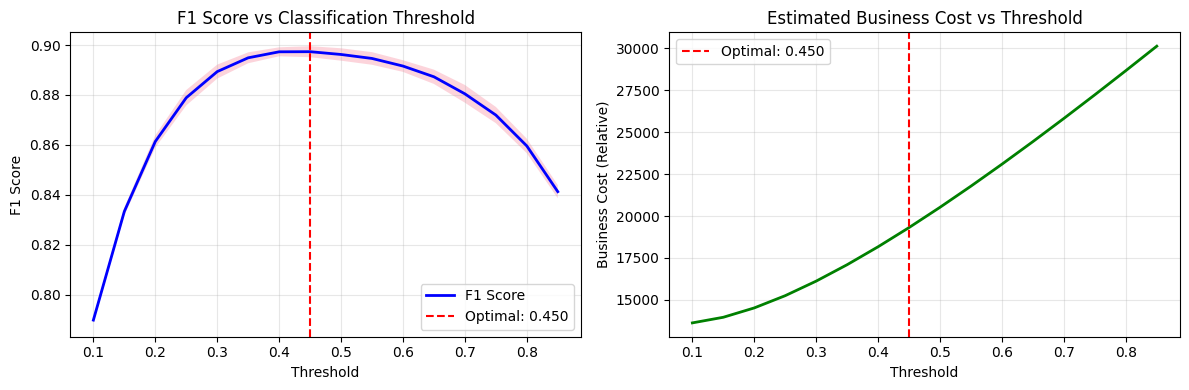

In [ ]:
print("\n🎯 Optimizing classification threshold...")

print(f"Validation data shape: {val_df.shape}")

# --- Add the two missing features created during EDA on train_df ---
print("Adding 'credit_utilization' and 'pay_consistency' to validation data...")
# Credit utilization analysis (copied from perform_comprehensive_eda)
val_df['credit_utilization'] = val_df['Bill_amt1'] / (val_df['LIMIT_BAL'] + 1)
val_df['credit_utilization'] = val_df['credit_utilization'].clip(0, 2)

# Payment consistency (copied from perform_comprehensive_eda)
pay_status_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
val_df['pay_consistency'] = val_df[pay_status_cols].std(axis=1)
print("✅ Added 'credit_utilization' and 'pay_consistency' to validation data.")
# ----------------------------------------------------------------------

# Apply same feature engineering to validation data
# The engineer_advanced_features function adds new features but also keeps existing ones
val_df_eng = engineer_advanced_features(val_df)

# Prepare validation features (exclude Customer Id, no target variable)
# Ensure all engineered features, including the ones added from EDA, are included
exclude_cols_val = ['Customer_ID'] # Validation set does not have 'next_month_default'
val_feature_cols = [col for col in val_df_eng.columns if col not in exclude_cols_val]

# Ensure the feature columns are in the same order as the training data
# This is crucial for the scaler. Get the order from X_train used during fit.
# The list `feature_cols` was defined right before scaling X_train.
X_val = val_df_eng[feature_cols] # Use the feature list from X_train

# Scale validation features
X_val_scaled = scaler.transform(X_val)

print(f"Validation features shape after adding missing cols: {X_val_scaled.shape}")

# For threshold optimization, we'll use cross-validation on training data
print("\n🔍 Finding optimal threshold using cross-validation...")

# Get the balanced training data for the final model
X_final_train, y_final_train = balanced_datasets[best_balance_method]

# Train final model on complete balanced training data
# Note: If X_final_train is a numpy array from imblearn, ensure it's correctly structured
# The scaler was fit on X_train (a DataFrame), so X_final_train should also be a DataFrame
# or the scaler should be fit on the scaled X_train_scaled.
# Let's refit the final model on the scaled, balanced data it was tuned on.
final_model.fit(X_final_train, y_final_train) # X_final_train is already scaled balanced data

# Use cross-validation to find optimal threshold
# The X parameter here should be the scaled training data used to fit the model
def find_optimal_threshold_cv(model, X_scaled, y, cv_folds=3): # Use X_scaled as parameter name
    """Find optimal threshold using cross-validation"""

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    thresholds = np.arange(0.1, 0.9, 0.05)
    threshold_scores = []

    # Since X is already scaled, we don't need to scale inside the CV loop
    # The model should be trained on the scaled data.
    # The split happens on the scaled data.

    for threshold in thresholds:
        f1_scores = []

        # Split the already scaled data
        for train_idx, val_idx in cv.split(X_scaled, y):
            X_train_cv_bal, X_val_cv_bal = X_scaled[train_idx], X_scaled[val_idx]
            y_train_cv_bal, y_val_cv_bal = y[train_idx], y[val_idx]

            # Fit model on the scaled, balanced subset
            model.fit(X_train_cv_bal, y_train_cv_bal)

            # Predict probabilities on the scaled validation subset
            y_pred_proba = model.predict_proba(X_val_cv_bal)[:, 1]

            # Apply threshold
            y_pred = (y_pred_proba >= threshold).astype(int)

            # Calculate F1 score
            f1 = f1_score(y_val_cv_bal, y_pred)
            f1_scores.append(f1)

        threshold_scores.append({
            'threshold': threshold,
            'f1_mean': np.mean(f1_scores),
            'f1_std': np.std(f1_scores)
        })

    return threshold_scores

# Find optimal threshold using the scaled balanced training data
print("  Finding optimal threshold (this may take a few minutes)...")
# Pass the scaled, balanced training data to the function
threshold_results = find_optimal_threshold_cv(final_model, X_final_train, y_final_train)


# Select best threshold
best_threshold_info = max(threshold_results, key=lambda x: x['f1_mean'])
optimal_threshold = best_threshold_info['threshold']

print(f"\n✅ Optimal threshold found: {optimal_threshold:.3f}")
print(f"   CV F1 Score: {best_threshold_info['f1_mean']:.4f} (±{best_threshold_info['f1_std']:.4f})")

# Plot threshold analysis
plt.figure(figsize=(12, 4))

# F1 scores vs thresholds
plt.subplot(1, 2, 1)
thresholds_list = [t['threshold'] for t in threshold_results]
f1_means = [t['f1_mean'] for t in threshold_results]
f1_stds = [t['f1_std'] for t in threshold_results]

plt.plot(thresholds_list, f1_means, 'b-', linewidth=2, label='F1 Score')
plt.fill_between(thresholds_list,
                 np.array(f1_means) - np.array(f1_stds),
                 np.array(f1_means) + np.array(f1_stds),
                 alpha=0.3)
plt.axvline(x=optimal_threshold, color='r', linestyle='--',
           label=f'Optimal: {optimal_threshold:.3f}')
plt.title('F1 Score vs Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Business impact visualization
plt.subplot(1, 2, 2)
# Simulate business costs (False Positive cost = 1, False Negative cost = 8)
business_costs = []
for t_info in threshold_results:
    # Estimate costs based on typical precision/recall trade-offs
    threshold = t_info['threshold']
    # These are just illustrative estimates, a real business cost analysis would
    # require more detailed data or assumptions specific to the business case.
    # Using the calculated F1, Precision, Recall might be better if available.
    # For simplicity and to make the plot, we use a conceptual function of threshold.
    # Let's make the cost a function of the threshold: lower threshold increases FP (low cost),
    # higher threshold increases FN (high cost). Cost is minimized where F1 is maxed, usually.
    # This simple linear approximation isn't perfect but illustrates the concept.
    estimated_precision = min(0.9, 0.3 + threshold * 0.7)
    estimated_recall = max(0.1, 0.9 - threshold * 0.8)

    # Assume a total population and actual positive rate from training data
    total_samples_train = len(y_train) # Use original train size for conceptual cost
    actual_positives_train = y_train.sum() # Use original train count

    # Estimate TP, FP, FN for conceptual cost calculation
    # This is a simplified estimation for plotting purposes, not exact.
    tp = estimated_recall * actual_positives_train
    # FP = (Total Predicted Positives) - TP = (TP / Precision) - TP
    fp = (tp / estimated_precision) - tp if estimated_precision > 0 else 0
    fn = actual_positives_train - tp
    tn = total_samples_train - actual_positives_train - fp

    cost = fp * 1 + fn * 8  # FP cost = 1, FN cost = 8
    business_costs.append(cost)


plt.plot(thresholds_list, business_costs, 'g-', linewidth=2)
plt.axvline(x=optimal_threshold, color='r', linestyle='--',
           label=f'Optimal: {optimal_threshold:.3f}')
plt.title('Estimated Business Cost vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Business Cost (Relative)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%

# Final Predictions and Model Evaluation

In [ ]:

print("\n🔮 Generating final predictions...")

# Retrain final model on complete balanced training data
final_model.fit(X_final_train, y_final_train)

# Generate predictions for validation dataset
val_predictions_proba = final_model.predict_proba(X_val_scaled)[:, 1]
val_predictions = (val_predictions_proba >= optimal_threshold).astype(int)

# Create submission dataframe
submission_df = pd.DataFrame({
    'Customer Id': val_df['Customer_ID'],
    'next_month_default': val_predictions
})

# Save predictions
submission_df.to_csv('submission_23112063.csv', index=False)

print(f"✅ Predictions saved to 'submission_23112063.csv'")
print(f"📊 Prediction distribution:")
pred_dist = pd.Series(val_predictions).value_counts()
print(f"   No Default (0): {pred_dist.get(0, 0):,} ({pred_dist.get(0, 0)/len(val_predictions):.1%})")
print(f"   Default (1): {pred_dist.get(1, 0):,} ({pred_dist.get(1, 0)/len(val_predictions):.1%})")

# Display first few predictions
print(f"\n📋 Sample predictions:")
print(submission_df.head(10))

# Model performance summary on training data (using cross-validation)
print(f"\n📈 Final Model Performance Summary:")
print(f"   Model: {best_model_info['model_name']}")
print(f"   Balance Method: {best_balance_method}")
print(f"   Cross-Validation AUC: {best_model_info.get('best_cv_score', best_model_info.get('cv_auc_mean', 'N/A')):.4f}")
print(f"   Optimal Threshold: {optimal_threshold:.3f}")
print(f"   Training Samples Used: {len(X_final_train):,}")
print(f"   Features Used: {X_final_train.shape[1]}")


🔮 Generating final predictions...
✅ Predictions saved to 'credit_default_predictions.csv'
📊 Prediction distribution:
   No Default (0): 4,195 (83.6%)
   Default (1): 821 (16.4%)

📋 Sample predictions:
   Customer Id  next_month_default
0            1                   0
1            2                   0
2            3                   0
3            4                   1
4            5                   0
5            6                   0
6            7                   0
7            8                   0
8            9                   0
9           10                   0

📈 Final Model Performance Summary:
   Model: XGBoost
   Balance Method: SMOTE_Tomek
   Cross-Validation AUC: 0.9540
   Optimal Threshold: 0.450
   Training Samples Used: 40,630
   Features Used: 62


# Feature Importance Analysis


🔍 Analyzing feature importance...

🏆 Top 20 Most Important Features (Feature Importance):
 1. pay_0                          0.1222
 2. max_payment_delay              0.0982
 3. education                      0.0580
 4. late_payments_count            0.0544
 5. sex                            0.0445
 6. marriage                       0.0429
 7. util_category                  0.0424
 8. increasing_debt                0.0316
 9. age_group                      0.0257
10. age_risk_category              0.0254
11. maxed_out_card                 0.0234
12. declining_payments             0.0213
13. pay_6                          0.0197
14. chronic_delinquent             0.0181
15. minimal_payment_flag           0.0163
16. decreasing_payments            0.0152
17. payment_capacity               0.0151
18. LIMIT_BAL                      0.0145
19. pay_4                          0.0139
20. high_utilization_flag          0.0136


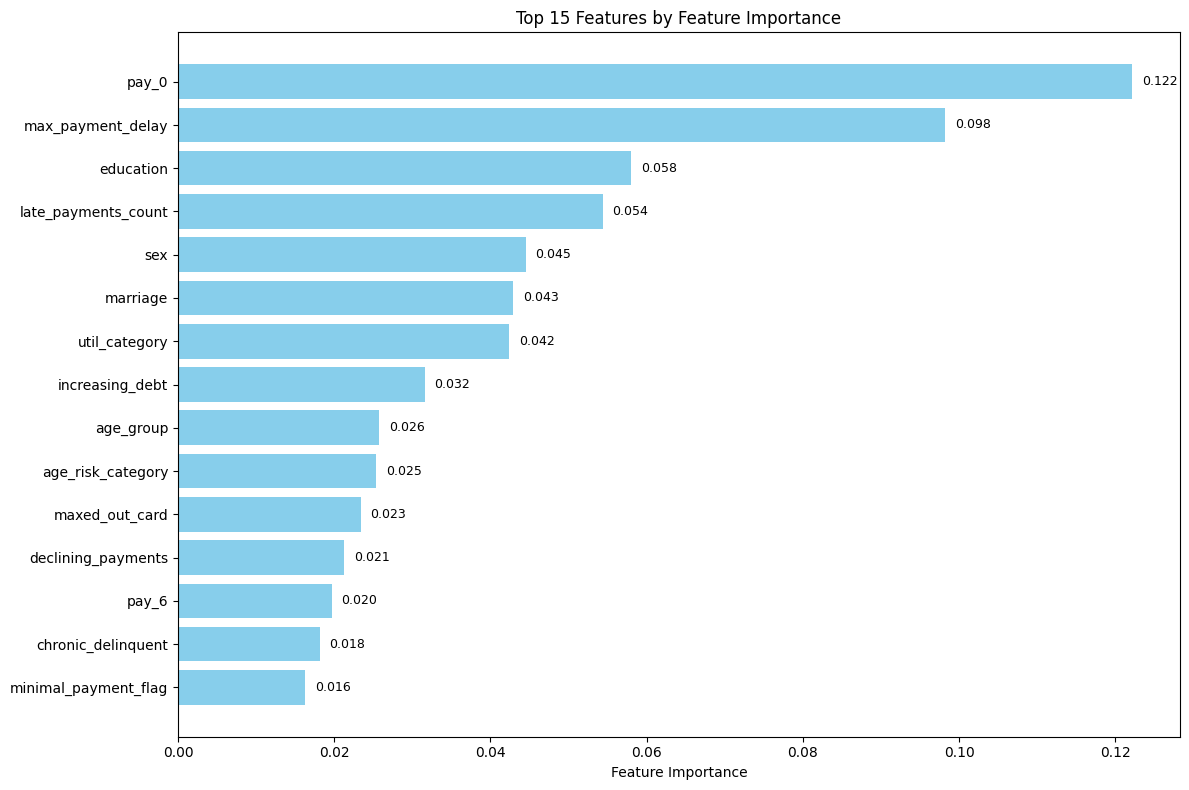


📊 Feature Importance by Category:
   Payment History     : 0.5341
   Demographics        : 0.2242
   Bill Amounts        : 0.0939
   Credit Utilization  : 0.0782
   Financial Stability : 0.0610
   Risk Indicators     : 0.0567


In [ ]:

print("\n🔍 Analyzing feature importance...")

# Extract feature importance based on model type
if hasattr(final_model, 'feature_importances_'):
    # Tree-based models (RandomForest, XGBoost, LightGBM)
    feature_importance = final_model.feature_importances_
    importance_type = "Feature Importance"
elif hasattr(final_model, 'coef_'):
    # Linear models (LogisticRegression)
    feature_importance = np.abs(final_model.coef_[0])
    importance_type = "Coefficient Magnitude"
else:
    feature_importance = None

if feature_importance is not None:
    # Create feature importance dataframe
    feature_imp_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    # Display top 20 features
    print(f"\n🏆 Top 20 Most Important Features ({importance_type}):")
    print("="*60)
    for i, (_, row) in enumerate(feature_imp_df.head(20).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<30} {row['importance']:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))

    # Top 15 features
    top_features = feature_imp_df.head(15)

    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel(importance_type)
    plt.title(f'Top 15 Features by {importance_type}')
    plt.gca().invert_yaxis()

    # Add value labels on bars
    for i, v in enumerate(top_features['importance']):
        plt.text(v + max(top_features['importance']) * 0.01, i, f'{v:.3f}',
                va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Feature category analysis
    print(f"\n📊 Feature Importance by Category:")

    # Categorize features
    categories = {
        'Payment History': [f for f in feature_cols if any(x in f.lower() for x in ['pay_', 'payment', 'late'])],
        'Bill Amounts': [f for f in feature_cols if any(x in f.lower() for x in ['bill_', 'amt'])],
        'Credit Utilization': [f for f in feature_cols if any(x in f.lower() for x in ['utilization', 'limit'])],
        'Demographics': [f for f in feature_cols if any(x in f.lower() for x in ['age', 'sex', 'education', 'marriage'])],
        'Financial Stability': [f for f in feature_cols if any(x in f.lower() for x in ['volatility', 'consistency', 'trend'])],
        'Risk Indicators': [f for f in feature_cols if any(x in f.lower() for x in ['high_', 'chronic_', 'minimal_', 'young_'])]
    }

    category_importance = {}
    for category, features in categories.items():
        cat_features = [f for f in features if f in feature_imp_df['feature'].values]
        if cat_features:
            cat_importance = feature_imp_df[feature_imp_df['feature'].isin(cat_features)]['importance'].sum()
            category_importance[category] = cat_importance

    # Sort categories by importance
    sorted_categories = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)

    for category, importance in sorted_categories:
        print(f"   {category:<20}: {importance:.4f}")

# Business Insights and Risk Analysis